# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time
wait_to_make = "trained_list/bert-large.txt"
count = 0
while 1:
    if os.path.exists(wait_to_make):
        break
    print(f'sleep {count} h')
    time.sleep(3600)
    count+=1
    
local = True

sleep 0 h
sleep 1 h
sleep 2 h
sleep 3 h


In [2]:
EXP_NAME = "google/electra-large-discriminator".replace("/","-")


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime
if local:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
else:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "google/electra-large-discriminator"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model or "medium" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

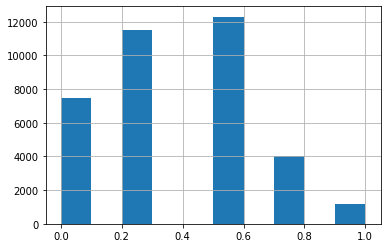

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.add_special_tokens({'pad_token': '[SEP]'})
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        try:
                if isinstance(module, nn.Linear):
                    module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.Embedding):
                    module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                    if module.padding_idx is not None:
                        module.weight.data[module.padding_idx].zero_()
                elif isinstance(module, nn.LayerNorm):
                    module.bias.data.zero_()
                    module.weight.data.fill_(1.0)
        except:
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    


# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            # if fold in [0,1,2]:
                #continue
               # print（f”￥０r３３［３８；５；４０m＝＝＝＝＝＝＝＝＝＝ this fold is pass ￥ontinue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 2s (remain 117m 16s) Loss: 0.6865(0.6865) Grad: 396214.9062  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 36s (remain 20m 0s) Loss: 0.6302(0.6529) Grad: 5918.8540  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 6s (remain 17m 46s) Loss: 0.6387(0.6491) Grad: 844.5046  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 36s (remain 16m 40s) Loss: 0.6670(0.6559) Grad: 108.3915  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 6s (remain 15m 52s) Loss: 0.5258(0.6555) Grad: 191.7083  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 36s (remain 15m 11s) Loss: 0.6275(0.6544) Grad: 42.3739  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 6s (remain 14m 34s) Loss: 0.6390(0.6555) Grad: 44.5181  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 3m 36s (remain 13m 59s) Loss: 0.6462(0.6560) Grad: 62.5935  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 6s (remain 13m 26s) Loss: 0.6706(0.6551) Grad: 109.9939  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 4m 36s (remain

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 11s) Loss: 0.5973(0.5973) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.6212(0.6537) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5258(0.6565) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.8119(0.6570) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.7642(0.6610) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6450(0.6595) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6450(0.6566) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6688(0.6564) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6688(0.6553) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.5735(0.6566) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6927(0.6579) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.6927(0.6587) 


Epoch 1 - avg_train_loss: 0.6563  avg_val_loss: 0.6590  time: 1125s
Epoch 1 - Score: 0.0141
Epoch 1 - Save Best Score: 0.0141 Model


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8459(0.6590) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 34m 45s) Loss: 0.7311(0.7311) Grad: 87111.3594  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 31s (remain 17m 12s) Loss: 0.7993(0.6640) Grad: 140510.6875  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 2s (remain 16m 37s) Loss: 0.7914(0.6588) Grad: 126511.7031  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 33s (remain 16m 5s) Loss: 0.7388(0.6606) Grad: 86946.1406  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 4s (remain 15m 33s) Loss: 0.7045(0.6599) Grad: 65588.3594  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 34s (remain 15m 2s) Loss: 0.7067(0.6582) Grad: 61698.2188  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 5s (remain 14m 31s) Loss: 0.8704(0.6587) Grad: 191436.7031  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 3m 36s (remain 13m 59s) Loss: 0.5975(0.6585) Grad: 40343.6250  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 7s (remain 13m 28s) Loss: 0.6720(0.6570) Grad: 35158.6992  LR: 0.00001566  
Epoch: [2][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 10s) Loss: 0.6059(0.6059) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.6248(0.6506) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5492(0.6528) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.7760(0.6532) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.7382(0.6564) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6437(0.6552) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6437(0.6529) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6626(0.6527) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6626(0.6518) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.5870(0.6529) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6815(0.6539) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.6815(0.6546) 


Epoch 2 - avg_train_loss: 0.6559  avg_val_loss: 0.6548  time: 1147s
Epoch 2 - Score: -0.0040


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8029(0.6548) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 21m 40s) Loss: 0.6427(0.6427) Grad: 26984.5566  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 31s (remain 17m 7s) Loss: 0.6406(0.6439) Grad: 26292.3301  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 2s (remain 16m 35s) Loss: 0.6855(0.6515) Grad: 40523.3867  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 1m 35s (remain 16m 27s) Loss: 0.6889(0.6523) Grad: 43856.3320  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 6s (remain 15m 50s) Loss: 0.6408(0.6517) Grad: 18950.9902  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 2m 37s (remain 15m 15s) Loss: 0.5593(0.6520) Grad: 102621.3672  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 8s (remain 14m 41s) Loss: 0.6296(0.6527) Grad: 36754.4102  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 3m 38s (remain 14m 8s) Loss: 0.6103(0.6543) Grad: 53567.8555  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 4m 9s (remain 13m 36s) Loss: 0.6322(0.6540) Grad: 33740.5977  LR: 0.00000817  
Epoch: [3][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 17m 38s (remain 0m 0s) Loss: 0.6659(0.6551) Grad: 52013.9961  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 16s) Loss: 0.6059(0.6059) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.6248(0.6506) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5491(0.6528) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.7761(0.6532) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.7383(0.6564) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6437(0.6552) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6437(0.6529) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6626(0.6527) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6626(0.6518) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.5869(0.6529) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6815(0.6539) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.6815(0.6546) 


Epoch 3 - avg_train_loss: 0.6551  avg_val_loss: 0.6548  time: 1150s
Epoch 3 - Score: 0.0307
Epoch 3 - Save Best Score: 0.0307 Model


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8031(0.6548) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 31m 0s) Loss: 0.6538(0.6538) Grad: 21193.7891  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 31s (remain 17m 12s) Loss: 0.6975(0.6557) Grad: 47431.7266  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 2s (remain 16m 37s) Loss: 0.7128(0.6541) Grad: 62305.9180  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 1m 33s (remain 16m 5s) Loss: 0.6071(0.6550) Grad: 53300.8164  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 4s (remain 15m 33s) Loss: 0.6458(0.6551) Grad: 22724.9902  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 2m 34s (remain 15m 2s) Loss: 0.6446(0.6553) Grad: 25735.7090  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 5s (remain 14m 31s) Loss: 0.6223(0.6541) Grad: 35532.5664  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 3m 36s (remain 14m 0s) Loss: 0.5430(0.6555) Grad: 95053.8672  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 4m 7s (remain 13m 29s) Loss: 0.6233(0.6560) Grad: 32689.2344  LR: 0.00000176  
Epoch: [4][900/3419] Elapsed 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 17m 36s (remain 0m 0s) Loss: 0.6015(0.6551) Grad: 70218.9766  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 16s) Loss: 0.6052(0.6052) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 24s) Loss: 0.6244(0.6506) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.5476(0.6529) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.7780(0.6532) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.7396(0.6565) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6436(0.6553) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6436(0.6530) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6628(0.6528) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6628(0.6519) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.5860(0.6530) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6820(0.6540) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.6820(0.6547) 


Epoch 4 - avg_train_loss: 0.6551  avg_val_loss: 0.6549  time: 1148s
Epoch 4 - Score: -0.0005


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8055(0.6549) 


========== fold: 0 result ==========
Score: 0.0307
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leak

Epoch: [1][0/3419] Elapsed 0m 0s (remain 22m 23s) Loss: 0.6830(0.6830) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 33s (remain 18m 33s) Loss: 0.6650(0.6594) Grad: 429.7178  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 4s (remain 17m 5s) Loss: 0.7994(0.6655) Grad: 1137.1238  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 34s (remain 16m 14s) Loss: 0.4838(0.6623) Grad: 1167.3691  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 4s (remain 15m 34s) Loss: 0.6437(0.6621) Grad: 139.7793  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 34s (remain 14m 58s) Loss: 0.6432(0.6607) Grad: 444.9750  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 4s (remain 14m 24s) Loss: 0.7658(0.6606) Grad: 618.6287  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 3m 34s (remain 13m 51s) Loss: 0.6343(0.6601) Grad: 302.3323  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 4s (remain 13m 19s) Loss: 0.6795(0.6600) Grad: 215.3342  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 4m 34s (remain 12m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 9s) Loss: 0.6435(0.6435) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 25s) Loss: 0.6435(0.6497) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 15s) Loss: 0.6031(0.6508) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.6233(0.6505) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.5627(0.6533) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.7445(0.6539) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.7647(0.6534) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.7243(0.6521) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6637(0.6530) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.7647(0.6543) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6435(0.6547) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.7041(0.6552) 


Epoch 1 - avg_train_loss: 0.6560  avg_val_loss: 0.6553  time: 1127s
Epoch 1 - Score: -0.0065


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6637(0.6553) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 23m 44s) Loss: 0.6659(0.6659) Grad: 12386.8867  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 31s (remain 17m 10s) Loss: 0.6826(0.6468) Grad: 24735.3945  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 2s (remain 16m 37s) Loss: 0.6008(0.6492) Grad: 30626.3691  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 33s (remain 16m 6s) Loss: 0.6669(0.6512) Grad: 16853.2559  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 4s (remain 15m 37s) Loss: 0.6356(0.6516) Grad: 19835.9492  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 35s (remain 15m 5s) Loss: 0.6226(0.6503) Grad: 21624.1582  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 6s (remain 14m 34s) Loss: 0.6480(0.6516) Grad: 15046.1787  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 3m 37s (remain 14m 3s) Loss: 0.5907(0.6522) Grad: 33367.6953  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 8s (remain 13m 31s) Loss: 0.6249(0.6527) Grad: 20152.2637  LR: 0.00001566  
Epoch: [2][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 17m 40s (remain 0m 0s) Loss: 0.7056(0.6548) Grad: 38514.0312  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 0s) Loss: 0.6435(0.6435) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 25s) Loss: 0.6435(0.6496) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 16s) Loss: 0.6041(0.6507) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.6238(0.6504) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.5647(0.6531) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.7421(0.6537) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.7618(0.6532) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.7224(0.6519) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6632(0.6528) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.7618(0.6541) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6435(0.6544) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.7027(0.6549) 


Epoch 2 - avg_train_loss: 0.6548  avg_val_loss: 0.6550  time: 1153s
Epoch 2 - Score: 0.0057
Epoch 2 - Save Best Score: 0.0057 Model


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6632(0.6550) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 38m 7s) Loss: 0.6064(0.6064) Grad: 29486.3398  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 31s (remain 17m 18s) Loss: 0.6213(0.6557) Grad: 22816.4883  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 2s (remain 16m 41s) Loss: 0.6604(0.6578) Grad: 12867.2305  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 1m 33s (remain 16m 8s) Loss: 0.6967(0.6535) Grad: 35425.4336  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 4s (remain 15m 36s) Loss: 0.6273(0.6535) Grad: 24737.4434  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 2m 35s (remain 15m 5s) Loss: 0.7573(0.6534) Grad: 69974.8750  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 6s (remain 14m 33s) Loss: 0.6398(0.6530) Grad: 15627.4229  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 3m 37s (remain 14m 2s) Loss: 0.6828(0.6541) Grad: 22416.6816  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 4m 8s (remain 13m 31s) Loss: 0.6296(0.6552) Grad: 25523.8047  LR: 0.00000817  
Epoch: [3][900/3419] Elapsed 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 1s (remain 23m 33s) Loss: 0.6440(0.6440) 
EVAL: [100/1140] Elapsed 0m 9s (remain 1m 35s) Loss: 0.6440(0.6496) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 20s) Loss: 0.6078(0.6506) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 10s) Loss: 0.6259(0.6503) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.5716(0.6528) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.7345(0.6533) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.7526(0.6529) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 35s) Loss: 0.7164(0.6517) 
EVAL: [800/1140] Elapsed 1m 5s (remain 0m 27s) Loss: 0.6621(0.6525) 
EVAL: [900/1140] Elapsed 1m 13s (remain 0m 19s) Loss: 0.7526(0.6537) 
EVAL: [1000/1140] Elapsed 1m 21s (remain 0m 11s) Loss: 0.6440(0.6540) 
EVAL: [1100/1140] Elapsed 1m 29s (remain 0m 3s) Loss: 0.6983(0.6545) 


Epoch 3 - avg_train_loss: 0.6549  avg_val_loss: 0.6546  time: 1151s
Epoch 3 - Score: -0.0025


EVAL: [1139/1140] Elapsed 1m 32s (remain 0m 0s) Loss: 0.6621(0.6546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 24m 44s) Loss: 0.5579(0.5579) Grad: 66707.2266  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 31s (remain 17m 13s) Loss: 0.6784(0.6554) Grad: 25290.3984  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 2s (remain 16m 40s) Loss: 0.6651(0.6602) Grad: 13901.1348  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 1m 33s (remain 16m 8s) Loss: 0.6743(0.6564) Grad: 19027.1523  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 4s (remain 15m 37s) Loss: 0.6419(0.6584) Grad: 16234.7256  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 2m 35s (remain 15m 6s) Loss: 0.7102(0.6585) Grad: 43553.2969  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 6s (remain 14m 34s) Loss: 0.6260(0.6586) Grad: 23809.8301  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 3m 37s (remain 14m 3s) Loss: 0.6075(0.6585) Grad: 35201.2461  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 4m 8s (remain 13m 32s) Loss: 0.7122(0.6579) Grad: 42143.7539  LR: 0.00000176  
Epoch: [4][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 14s) Loss: 0.6439(0.6439) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 25s) Loss: 0.6439(0.6495) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 16s) Loss: 0.6070(0.6506) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.6254(0.6503) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.5701(0.6528) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.7361(0.6534) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.7545(0.6529) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.7176(0.6517) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6623(0.6525) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.7545(0.6537) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6439(0.6540) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.6992(0.6545) 


Epoch 4 - avg_train_loss: 0.6548  avg_val_loss: 0.6546  time: 1151s
Epoch 4 - Score: -0.0043


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6623(0.6546) 


========== fold: 1 result ==========
Score: 0.0057
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leak

Epoch: [1][0/3419] Elapsed 0m 0s (remain 22m 30s) Loss: 0.7277(0.7277) Grad: nan  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 31s (remain 17m 14s) Loss: 0.7806(0.6697) Grad: 1231.1213  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 1s (remain 16m 26s) Loss: 0.6608(0.6653) Grad: 466.3427  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 31s (remain 15m 50s) Loss: 0.6474(0.6614) Grad: 261.3877  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 1s (remain 15m 17s) Loss: 0.6973(0.6594) Grad: 460.6434  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 32s (remain 14m 45s) Loss: 0.6253(0.6590) Grad: 287.6349  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 2s (remain 14m 14s) Loss: 0.6918(0.6580) Grad: 360.6165  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 3m 32s (remain 13m 43s) Loss: 0.6666(0.6589) Grad: 158.8717  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 2s (remain 13m 12s) Loss: 0.6296(0.6581) Grad: 299.9543  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 4m 32s (remain 12m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 17m 12s (remain 0m 0s) Loss: 0.6651(0.6562) Grad: 315.6607  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 17m 48s) Loss: 0.6241(0.6241) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.7019(0.6586) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 19s) Loss: 0.6436(0.6519) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 9s) Loss: 0.7992(0.6536) 
EVAL: [400/1140] Elapsed 0m 32s (remain 1m 0s) Loss: 0.6825(0.6579) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 52s) Loss: 0.6630(0.6528) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6825(0.6529) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 35s) Loss: 0.6241(0.6536) 
EVAL: [800/1140] Elapsed 1m 5s (remain 0m 27s) Loss: 0.6046(0.6533) 
EVAL: [900/1140] Elapsed 1m 13s (remain 0m 19s) Loss: 0.6436(0.6535) 
EVAL: [1000/1140] Elapsed 1m 21s (remain 0m 11s) Loss: 0.6241(0.6548) 
EVAL: [1100/1140] Elapsed 1m 29s (remain 0m 3s) Loss: 0.7603(0.6549) 


Epoch 1 - avg_train_loss: 0.6562  avg_val_loss: 0.6549  time: 1126s
Epoch 1 - Score: -0.0054


EVAL: [1139/1140] Elapsed 1m 32s (remain 0m 0s) Loss: 0.7668(0.6549) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 24m 53s) Loss: 0.6407(0.6407) Grad: 15452.2559  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 31s (remain 17m 13s) Loss: 0.6424(0.6543) Grad: 16529.4414  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 2s (remain 16m 40s) Loss: 0.5897(0.6562) Grad: 47463.4570  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 33s (remain 16m 8s) Loss: 0.5921(0.6567) Grad: 50216.1055  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 4s (remain 15m 37s) Loss: 0.5952(0.6546) Grad: 46165.3594  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 35s (remain 15m 6s) Loss: 0.7229(0.6539) Grad: 60178.0273  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 6s (remain 14m 34s) Loss: 0.5726(0.6545) Grad: 56459.6445  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 3m 37s (remain 14m 3s) Loss: 0.7146(0.6542) Grad: 44875.0781  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 8s (remain 13m 32s) Loss: 0.7575(0.6540) Grad: 73806.0625  LR: 0.00001566  
Epoch: [2][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 17m 40s (remain 0m 0s) Loss: 0.6944(0.6549) Grad: 34013.6406  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 26s) Loss: 0.6252(0.6252) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 25s) Loss: 0.6996(0.6582) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 16s) Loss: 0.6438(0.6517) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.7926(0.6534) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.6810(0.6575) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6624(0.6527) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6810(0.6528) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6252(0.6534) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6066(0.6531) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.6438(0.6533) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6252(0.6545) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.7554(0.6547) 


Epoch 2 - avg_train_loss: 0.6549  avg_val_loss: 0.6547  time: 1153s
Epoch 2 - Score: 0.0071
Epoch 2 - Save Best Score: 0.0071 Model


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.7616(0.6547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 33m 35s) Loss: 0.5760(0.5760) Grad: 62271.6328  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 31s (remain 17m 16s) Loss: 0.6576(0.6481) Grad: 17129.3027  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 2s (remain 16m 40s) Loss: 0.6610(0.6509) Grad: 14862.4014  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 1m 33s (remain 16m 8s) Loss: 0.5316(0.6521) Grad: 77171.1328  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 4s (remain 15m 36s) Loss: 0.6618(0.6527) Grad: 20145.0918  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 2m 35s (remain 15m 4s) Loss: 0.6252(0.6511) Grad: 18299.8750  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 6s (remain 14m 33s) Loss: 0.6963(0.6515) Grad: 36360.6602  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 3m 37s (remain 14m 2s) Loss: 0.5856(0.6522) Grad: 44306.6719  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 4m 8s (remain 13m 31s) Loss: 0.7369(0.6526) Grad: 58334.0977  LR: 0.00000817  
Epoch: [3][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 17m 38s (remain 0m 0s) Loss: 0.6272(0.6550) Grad: 24129.3789  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 2s (remain 55m 6s) Loss: 0.6245(0.6245) 
EVAL: [100/1140] Elapsed 0m 10s (remain 1m 52s) Loss: 0.7010(0.6584) 
EVAL: [200/1140] Elapsed 0m 18s (remain 1m 28s) Loss: 0.6436(0.6518) 
EVAL: [300/1140] Elapsed 0m 27s (remain 1m 16s) Loss: 0.7966(0.6535) 
EVAL: [400/1140] Elapsed 0m 35s (remain 1m 5s) Loss: 0.6819(0.6577) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.6627(0.6527) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.6819(0.6529) 
EVAL: [700/1140] Elapsed 0m 59s (remain 0m 37s) Loss: 0.6245(0.6535) 
EVAL: [800/1140] Elapsed 1m 7s (remain 0m 28s) Loss: 0.6054(0.6532) 
EVAL: [900/1140] Elapsed 1m 15s (remain 0m 20s) Loss: 0.6436(0.6534) 
EVAL: [1000/1140] Elapsed 1m 23s (remain 0m 11s) Loss: 0.6245(0.6547) 
EVAL: [1100/1140] Elapsed 1m 31s (remain 0m 3s) Loss: 0.7583(0.6548) 


Epoch 3 - avg_train_loss: 0.6550  avg_val_loss: 0.6548  time: 1154s
Epoch 3 - Score: -0.0075


EVAL: [1139/1140] Elapsed 1m 35s (remain 0m 0s) Loss: 0.7647(0.6548) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 24m 46s) Loss: 0.6826(0.6826) Grad: 29878.1406  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 31s (remain 17m 13s) Loss: 0.6227(0.6604) Grad: 26091.9160  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 2s (remain 16m 40s) Loss: 0.6321(0.6562) Grad: 22255.3730  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 1m 33s (remain 16m 8s) Loss: 0.6470(0.6533) Grad: 17454.1816  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 4s (remain 15m 37s) Loss: 0.7284(0.6524) Grad: 50475.2383  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 2m 35s (remain 15m 6s) Loss: 0.6608(0.6523) Grad: 22280.0410  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 6s (remain 14m 34s) Loss: 0.5690(0.6536) Grad: 52354.7422  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 3m 37s (remain 14m 3s) Loss: 0.6077(0.6546) Grad: 31798.5059  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 4m 8s (remain 13m 32s) Loss: 0.5522(0.6538) Grad: 66509.7969  LR: 0.00000176  
Epoch: [4][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 17m 40s (remain 0m 0s) Loss: 0.6401(0.6550) Grad: 15506.8613  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 18s) Loss: 0.6249(0.6249) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 25s) Loss: 0.7002(0.6583) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 16s) Loss: 0.6437(0.6518) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.7943(0.6534) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.6814(0.6576) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6625(0.6527) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6814(0.6528) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6249(0.6535) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6061(0.6531) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.6437(0.6533) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6249(0.6546) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.7567(0.6547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 4 - avg_train_loss: 0.6550  avg_val_loss: 0.6547  time: 1153s
Epoch 4 - Score: -0.0073


EVAL: [1139/1140] Elapsed 1m 31s (remain 0m 0s) Loss: 0.7629(0.6547) 


========== fold: 2 result ==========
Score: 0.0071
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leak

Epoch: [1][0/3419] Elapsed 0m 0s (remain 23m 2s) Loss: 0.6221(0.6221) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 1m 25s (remain 46m 38s) Loss: 0.7331(0.6753) Grad: 2336.4431  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 55s (remain 30m 52s) Loss: 0.6290(0.6680) Grad: 378.0578  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 2m 26s (remain 25m 14s) Loss: 0.6212(0.6623) Grad: 704.3948  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 56s (remain 22m 9s) Loss: 0.6369(0.6602) Grad: 1308.7499  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 3m 27s (remain 20m 5s) Loss: 0.7243(0.6596) Grad: 1477.6963  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 57s (remain 18m 33s) Loss: 0.6297(0.6596) Grad: 693.7866  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 27s (remain 17m 18s) Loss: 0.5416(0.6595) Grad: 1912.8192  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 58s (remain 16m 14s) Loss: 0.6095(0.6580) Grad: 745.0331  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 6m 1s (remain 1

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 19m 24s (remain 0m 0s) Loss: 0.6141(0.6565) Grad: 1604.1934  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 48s) Loss: 0.6618(0.6618) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 25s) Loss: 0.6792(0.6444) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 16s) Loss: 0.7139(0.6539) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 7s) Loss: 0.5576(0.6511) 
EVAL: [400/1140] Elapsed 0m 32s (remain 0m 59s) Loss: 0.6444(0.6536) 
EVAL: [500/1140] Elapsed 0m 40s (remain 0m 51s) Loss: 0.6618(0.6533) 
EVAL: [600/1140] Elapsed 0m 48s (remain 0m 43s) Loss: 0.7486(0.6541) 
EVAL: [700/1140] Elapsed 0m 56s (remain 0m 35s) Loss: 0.6097(0.6541) 
EVAL: [800/1140] Elapsed 1m 4s (remain 0m 27s) Loss: 0.6444(0.6532) 
EVAL: [900/1140] Elapsed 1m 12s (remain 0m 19s) Loss: 0.6792(0.6534) 
EVAL: [1000/1140] Elapsed 1m 20s (remain 0m 11s) Loss: 0.6097(0.6544) 
EVAL: [1100/1140] Elapsed 1m 28s (remain 0m 3s) Loss: 0.6965(0.6543) 


Epoch 1 - avg_train_loss: 0.6565  avg_val_loss: 0.6546  time: 1257s
Epoch 1 - Score: -0.0091


EVAL: [1139/1140] Elapsed 1m 32s (remain 0m 0s) Loss: 0.7312(0.6546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 25m 37s) Loss: 0.6287(0.6287) Grad: 31658.3633  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 31s (remain 17m 16s) Loss: 0.5650(0.6642) Grad: 87582.4141  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 5s (remain 17m 23s) Loss: 0.6165(0.6611) Grad: 45242.3984  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 36s (remain 16m 43s) Loss: 0.6787(0.6601) Grad: 20582.5059  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 9s (remain 16m 14s) Loss: 0.6338(0.6606) Grad: 31541.4766  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 42s (remain 15m 46s) Loss: 0.6953(0.6602) Grad: 33632.9492  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 15s (remain 15m 14s) Loss: 0.6679(0.6610) Grad: 22534.7168  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 3m 48s (remain 14m 47s) Loss: 0.7061(0.6592) Grad: 39647.9531  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 22s (remain 14m 18s) Loss: 0.6468(0.6585) Grad: 18753.4160  LR: 0.00001566  
Epoch: [2][900/3419] Ela

In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
!touch trained_list/electra-large.txt

In [ ]:
LOGGER.info(f"max_len: {CFG.max_len}")